In [0]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os

import tensorflow as tf
print(tf.__version__)

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


1.15.0


In [0]:
# Load the data
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:15000], Target[:15000]
        validData, validTarget = Data[15000:16000], Target[15000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget

# Implementation of a neural network using only Numpy - trained using gradient descent with momentum
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest


def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target


# def relu(x):
#     # TODO

# def softmax(x):
#     # TODO


# def computeLayer(X, W, b):
#     # TODO

# def CE(target, prediction):

#     # TODO

# def gradCE(target, prediction):

#     # TODO


In [0]:
trainX, validX, testX, trainY, validY, testY = loadData()

Exception ignored in: <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7f3843f972b0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 230, in __del__
    self.close()
  File "/usr/local/lib/python3.6/dist-packages/numpy/lib/npyio.py", line 221, in close
    if self.zip is not None:
AttributeError: 'NpzFile' object has no attribute 'zip'


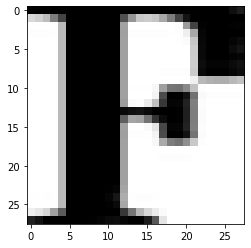

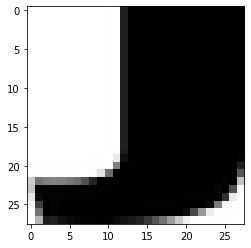

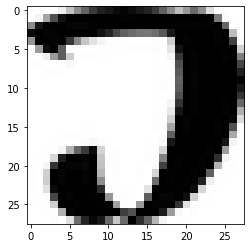

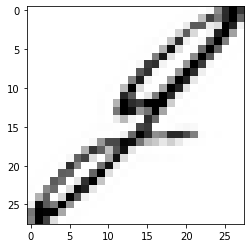

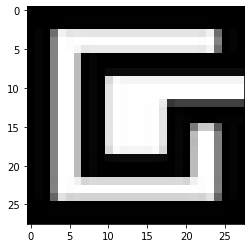

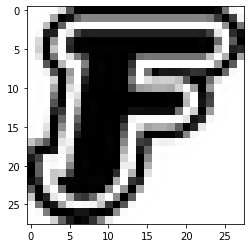

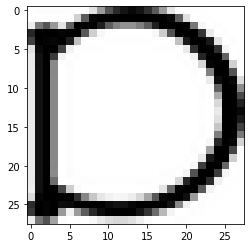

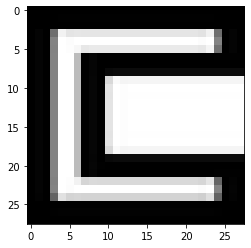

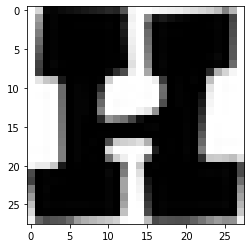

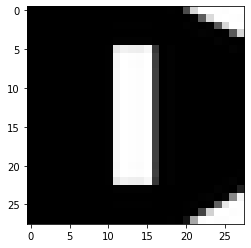

In [0]:
for i in range(0,10): # Visualize the data
    plt.figure()
    plt.imshow(trainX[i], cmap='Greys')
    plt.show()

# Part 1: NN using Numpy

## 1.1 Helper Functions

In [0]:
def relu(x):  
    return np.maximum(x, 0)

In [0]:
def softmax(x):
  maxVal = np.amax(x, axis = 1)
  newX = x - maxVal[:, None]
  sumX = np.sum(np.exp(newX), axis = 1, keepdims=True)
  result = np.exp(newX)/sumX

  return result

In [0]:
def computeLayer(X, W, b):
  return np.matmul(X,W) + b

In [0]:
def CE(target, prediction):
  summation = np.sum(np.sum(target * np.log(prediction + 1e-15), axis = 1))
  return -1 * summation/target.shape[0]

In [0]:
def softmaxDerivative(i, j, xi, xj):
  if (i==j):
    return softmax(xi)*(1-softmax(xj))
  
  else:
    return -1*softmax(xi) * softmax(xj)

In [0]:
def gradCE(target, predictionInput):
  derivativeOfInput = predictionInput - target # [0.1, 0.1, 0.1, 0.9 ... ] - [0, 0, 0, 1, ....]
  return derivativeOfInput

In [0]:
Y = np.array([[0 , 1, 0], [1, 0 , 0]])
YPred = np.array([[0.05 , 0.9, 0.05], [0.1, 0.8 , 0.1]])
gradCE(Y, YPred) # Works

array([[ 0.05, -0.1 ,  0.05],
       [-0.9 ,  0.8 ,  0.1 ]])

## 1.2 and 1.3: Learning

In [0]:
def relusign(matrix):
  reluMatrix = relu(matrix)
  reluMatrix[reluMatrix<=0] = 0
  reluMatrix[reluMatrix>0] = 1
  return reluMatrix

In [0]:
def forwardPropagation(X, W1, W2, b1, b2):
  z=computeLayer(X, W1, b1)
  z1=relu(z)

  z2=computeLayer(z1, W2, b2)
  y_hat=softmax(z2)
  
  return y_hat

In [0]:
def accuracy(y_pred, y):
    max_pred=np.argmax(y_pred, axis=1)
    max_targ=np.argmax(y, axis=1)

    diff = max_targ - max_pred
    correctPred = np.count_nonzero(diff == 0)

    return correctPred/(y_pred.shape[0])

In [0]:
def generatePlot(x_val, y_val_train, y_val_valid, y_val_test, title, xlabel, ylabel, yupper):
    plt.figure(figsize=(8, 6))
   
    plt.plot(x_val,y_val_train, label="training")
    plt.plot(x_val,y_val_test, label="test")
    plt.plot(x_val,y_val_valid, label="validation")
    plt.ylim(0, yupper)    
    plt.legend(loc='upper right')        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

In [0]:
def gradient_descent(iterations, numhiddenunits):
  W1 = np.random.normal(0, np.sqrt(2/(784+numhiddenunits)), (784, numhiddenunits)) #should be 1000 outputs going into the hidden layer
  W2 = np.random.normal(0, np.sqrt(2/(10+numhiddenunits)), (numhiddenunits, 10)) #10 outputs for output layer

  b1=np.zeros(numhiddenunits)
  b2=np.zeros(10)

  alpha=1e-5
  gamma=0.99
  v1=np.full((784, numhiddenunits), 1e-5)
  v2=np.full((numhiddenunits, 10), 1e-5)
  oneHotTrainY, oneHotValidY, oneHotTestY=convertOneHot(trainY, validY, testY)
  minloss=3
  minlossepoch=0
  X=[]
  X_v=[]
  X_t=[]
  for j in range(0, trainX.shape[0]):
    X.insert(j,trainX[j].flatten())

  for j in range(0, validX.shape[0]):
    X_v.insert(j,validX[j].flatten())

  for j in range(0, testX.shape[0]):
    X_t.insert(j,testX[j].flatten())

  X=np.array(X)
  X_v=np.array(X_v)
  X_t=np.array(X_t)
  
  acc_train_list=[]
  acc_test_list=[]
  acc_val_list=[]

  loss_train_list=[]
  loss_test_list=[]
  loss_val_list=[]

  for step in range(0, iterations):

    y_h=forwardPropagation(X, W1, W2, b1, b2)
    y_v=forwardPropagation(X_v, W1, W2, b1, b2)
    y_t=forwardPropagation(X_t, W1, W2, b1, b2)
    print("**************************************************************", step)
 
    acc_train=accuracy(y_h, oneHotTrainY)
    acc_valid=accuracy(y_v, oneHotValidY)
    acc_test=accuracy(y_t, oneHotTestY)
    print("what is the tr accuracy: ", acc_train)
    print("what is the v accuracy: ", acc_valid)
    print("what is the t accuracy: ", acc_test)


    loss_train=CE(oneHotTrainY, y_h)
    loss_valid=CE(oneHotValidY, y_v)
    loss_test=CE(oneHotTestY, y_t)
    print('what is the loss ',loss_train)
    print('what is the loss v ',loss_valid)
    print('what is the loss test',loss_test)

    if (loss_test < minloss):
      minloss=loss_test
      minlossepoch=step

    acc_train_list.append(acc_train)
    acc_val_list.append(acc_valid)
    acc_test_list.append(acc_test)
    loss_train_list.append(loss_train)
    loss_test_list.append(loss_test)
    loss_val_list.append(loss_valid)

    z1=computeLayer(X, W1, b1)
    sign=relusign(z1)
    gradient=gradCE(oneHotTrainY, y_h)
    derivativeW1=np.matmul(gradient, W2.T)

    derivativeW1=(np.multiply(derivativeW1, sign)).T.dot(X) #784x1000

    derivativeb1=np.multiply(gradient.dot(W2.T), sign)
    derivativeb1=np.sum(derivativeb1, axis=0) #1x1000
    
    derivativeb2= np.sum(gradient, axis=0) #1x10

    derivativeW2=(gradient.T).dot(relu(z1))

    v1=gamma*v1+alpha*derivativeW1.T

    v2=gamma*v2+alpha*derivativeW2.T

    W1-=v1
    W2-=v2

    b1=b1-alpha*derivativeb1
    b2=b2-alpha*derivativeb2

  print("min loss is "+str(minloss)+" at epoch "+str(minlossepoch))
  return acc_train_list, acc_val_list, acc_test_list, loss_train_list, loss_val_list, loss_test_list

#acc_train, acc_val, acc_test, loss_train, loss_val, loss_test = gradient_descent(200, 1000)


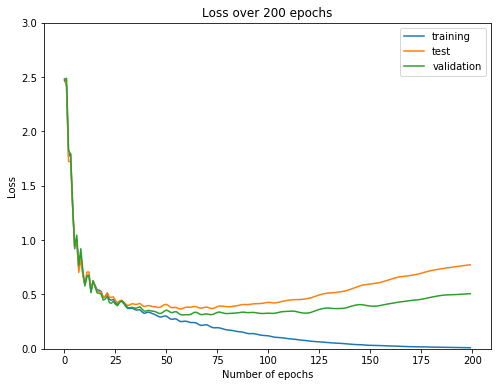

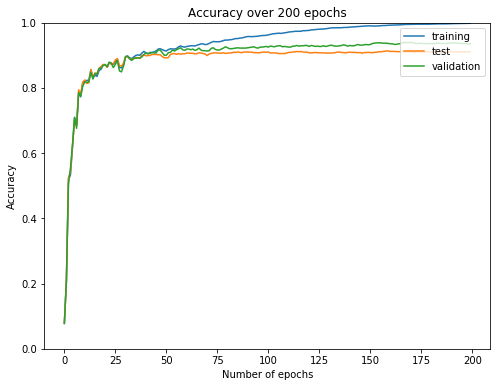

In [0]:
generatePlot(range(200), loss_train, loss_val, loss_test, "Loss over 200 epochs", "Number of epochs", "Loss", 3)
generatePlot(range(200), acc_train, acc_val, acc_test, "Accuracy over 200 epochs", "Number of epochs", "Accuracy", 1)


## 1.4 Hyperparameter Tuning

In [0]:
acc_train_100, acc_val_100, acc_test_100, loss_train_100, loss_val_100, loss_test_100 = gradient_descent(200, 100)
acc_train_500, acc_val_500, acc_test_500, loss_train_500, loss_val_500, loss_test_500 = gradient_descent(200, 500)
acc_train_2000, acc_val_2000, acc_test_2000, loss_train_2000, loss_val_2000, loss_test_2000 = gradient_descent(200, 2000)


************************************************************** 0
what is the tr accuracy:  0.11553333333333334
what is the v accuracy:  0.134
what is the t accuracy:  0.1130690161527166
what is the loss  2.58915010814696
what is the loss v  2.554886024173392
what is the loss test 2.6103203336535787
************************************************************** 0
what is the tr accuracy:  0.11553333333333334
what is the v accuracy:  0.134
what is the t accuracy:  0.1130690161527166
what is the loss  2.58915010814696
what is the loss v  2.554886024173392
what is the loss test 2.6103203336535787
************************************************************** 1
what is the tr accuracy:  0.24373333333333333
what is the v accuracy:  0.26
what is the t accuracy:  0.24192364170337738
what is the loss  2.1419081900638
what is the loss v  2.1516103473391386
what is the loss test 2.1352502444759853
************************************************************** 1
what is the tr accuracy:  0.2437333

In [0]:
def generateTestPlot(x_val, y_val_train, y_val_valid, y_val_test, title, xlabel, ylabel, yupper):
    plt.figure(figsize=(8, 6))
   
    plt.plot(x_val,y_val_train, label="100 hidden units")
    plt.plot(x_val,y_val_valid, label="500 hidden units")
    plt.plot(x_val,y_val_test, label="2000 hidden units")
    plt.ylim(0, yupper)    
    plt.legend(loc='bottom right')        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Unrecognized location 'bottom right'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.
  


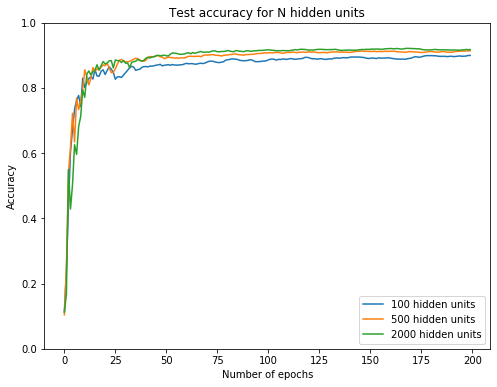

In [0]:
generateTestPlot(range(200), acc_test_100, acc_test_500, acc_test_2000, "Test accuracy for N hidden units", "Number of epochs", "Accuracy", 1)


# Part 2: Neural Networks in Tensorflow 


## 2.1 and 2.2

In [0]:
def convertOneHot(trainTarget, validTarget, testTarget):
  newtrain = np.zeros((trainTarget.shape[0], 10))
  newvalid = np.zeros((validTarget.shape[0], 10))
  newtest = np.zeros((testTarget.shape[0], 10))
  for item in range(0, trainTarget.shape[0]):
    newtrain[item][trainTarget[item]] = 1
  for item in range(0, validTarget.shape[0]):
    newvalid[item][validTarget[item]] = 1
  for item in range(0, testTarget.shape[0]):
    newtest[item][testTarget[item]] = 1
  return newtrain, newvalid, newtest

In [0]:
trainY, validY, testY = convertOneHot(trainY, validY, testY)

In [0]:
trainX = np.reshape(trainX, (-1, 28, 28, 1))
validX = np.reshape(validX, (-1, 28, 28, 1))
testX = np.reshape(testX, (-1, 28, 28, 1))


In [0]:
class TestCallback(tf.keras.callbacks.Callback):
    def __init__(self, test_data, testLoss):
        self.test_data = test_data
        self.testLoss = testLoss

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=0)
        print('\nTesting loss: {}, acc: {}\n'.format(loss, acc))
        self.testLoss.append((epoch, loss, acc))

In [0]:
## KERAS
def buildModel(beta, dropout_rate):
    model = tf.keras.Sequential()
    glorot_normal_init = tf.keras.initializers.glorot_normal(seed=421)
          
    # Conv Layer + Relu
    conv_layer = tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), padding='same',
                                        kernel_initializer=glorot_normal_init, activation='relu')
    model.add(conv_layer)

    # Batch Normalizatoin
    model.add(tf.keras.layers.BatchNormalization())
    
    # Max Pooling
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # FC1
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(784, kernel_initializer=glorot_normal_init, 
                                    kernel_regularizer=tf.keras.regularizers.l2(beta)))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Activation('relu'))

    # FC2
    model.add(tf.keras.layers.Dense(10, kernel_initializer=glorot_normal_init, 
                                    kernel_regularizer=tf.keras.regularizers.l2(beta), activation='softmax'))

    #LOSS
    adam= tf.keras.optimizers.Adam(learning_rate = 1e-4)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

    return model

In [0]:
def train(beta, dropout_rate):
  testLoss = []
  model = buildModel(beta, dropout_rate)
  model_history = model.fit(trainX, trainY, 32, 50, shuffle=True, validation_data=(validX, validY), callbacks=[TestCallback((testX, testY), testLoss)])
  return model_history, testLoss

In [0]:
def generate_plot(history, testLoss):
  plt.plot(history.history['acc'])
  plt.plot(history.history['val_acc'])
  testAcc = [testData[2] for testData in testLoss]
  plt.plot(testAcc)
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation', 'test'], loc='upper left')
  plt.show()
  # summarize history for loss
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  testLoss = [testData[1] for testData in testLoss]
  plt.plot(testLoss)
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation', 'test'], loc='upper left')
  plt.show()  

In [0]:
history, testLoss = train(0,0)
generate_plot(history, testLoss)

## 2.3

### 2.3.1 L2 *Regularization*

In [0]:
history, testLoss = train(0.01, 0) # reg = 0.01
generate_plot(history, testLoss)

In [0]:
history, testLoss = train(0.1, 0) # reg = 0.1
generate_plot(history, testLoss)

In [0]:
history, testLoss = train(0.5, 0) # reg = 0.5
generate_plot(history, testLoss)

### 2.3.2 Dropout

In [0]:
history, testLoss = train(0, 0.9) # dropout_rate = 0.9
generate_plot(history, testLoss)

In [0]:
history, testLoss = train(0, 0.75) # dropout_rate = 0.75
generate_plot(history, testLoss)

In [0]:
history, testLoss = train(0, 0.5) # dropout_rate = 0.5
generate_plot(history, testLoss)